# Convergence and metrics analysis for 3 nominally identical 3D printers case study

written by Christina Schenk, Miguel Hernández-del-Valle

last updated on 8 Oct 2025

tested on Christina's Mac, Miguel's Mac

This notebook performs convergence and metrics evolution analysis and generates associated plots for the case study of 3 nominally identical 3D printers presented in "Noise-Aware Optimization in Nominally Identical Measuring Systems for High-Throughput Parallel Workflows Manuscript" by Christina Schenk et al. (2025).

The steps of the workflow are the following:
1.1 Check convergence for single optimization and plot
1.2. Calculate single optimization metrics and plot
2.1. Check convergence for multi optimization and plot
2.2. Calculate multi optimization metrics and plot

### Import python packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Functions for computing metrics

In [2]:
# Function to compute MSE, RMSE, and MAE
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

### 1.1 Check convergence for single optimization and plot

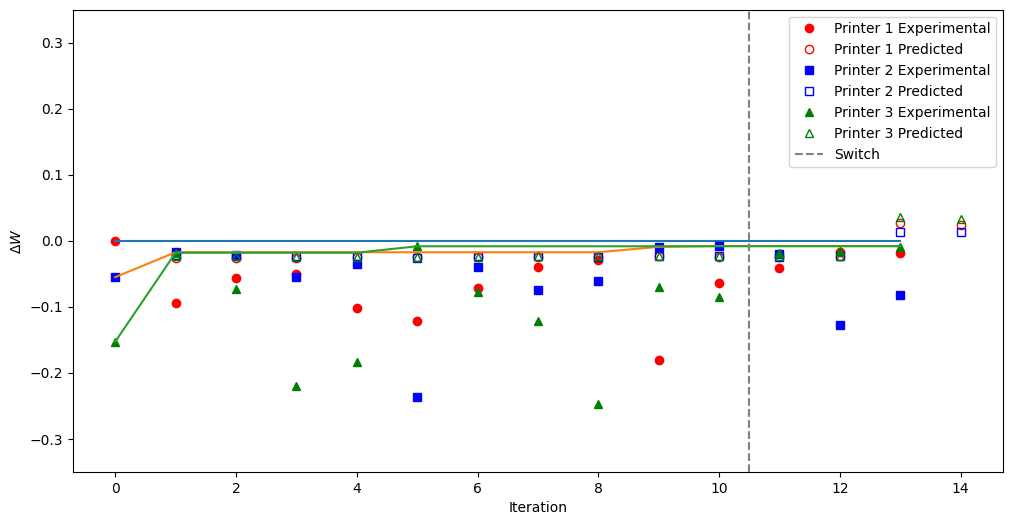

In [ ]:
volume = 80 * 13 * 3.2 * 1e-3
expected_density = 1.24  # from PLA datasheet
expected_weight = volume * expected_density
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']  # printer 1 circle, 2 square, 3 triangle

plt.figure(figsize=(12, 6))

for j in range(1, 4):
    data_single = pd.read_csv("../data/data-experiment-Feb2025-P"+str(j)+"_15.csv")
    clean_data = np.array(pd.Series(data_single['W_P'+str(j)][225:]).dropna().tolist())
    reshaped = clean_data.reshape(-1, 3)
    reduced = np.mean(reshaped, axis=1)

    W = - abs(1 - reduced/expected_weight)
    iterations = range(len(W))

    predictions = []
    for i in range(0, 14):
        with open("../BO/Metadata/metadata_after_BOP"+str(j)+"_"+str(i+1)+"_Feb2025.yaml") as stream:
            try:
                metadata = yaml.safe_load(stream)
                predictions.append(eval(metadata["values"])[0][0]*-1)
            except yaml.YAMLError as exc:
                print(exc)

    max_multi = W[0]
    current_max = []
    for value in W:
        if value > max_multi:
            max_multi = value
        current_max.append(max_multi)
    iterpred = range(1, len(predictions) + 1)

    # Plot experimental points with solid markers
    plt.plot(iterations, W, marker=markers[j-1], linestyle='None', color=colors[j-1], label=f'Printer {j} Experimental')
    # Plot predicted points with non-filled markers
    plt.plot(iterpred, predictions, marker=markers[j-1], linestyle='None', fillstyle='none', color=colors[j-1], label=f'Printer {j} Predicted')
    # Plot current max line
    plt.plot(iterations, current_max, linestyle='-')#, color=colors[j-1], label=f'Printer {j} Max')

# Add vertical line once
plt.axvline(x=10.5, color='gray', linestyle='--', label='Switch')

#plt.title('Convergence Plot, Combined Printers')
plt.xlabel('Iteration')
plt.ylabel('$\Delta W$')
plt.ylim([-0.35, 0.35])

# Manage legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')

plt.savefig("Figures_Postprocessing/singleopt_convergence_plot_all.png", format='png', dpi=600)
plt.show()


### 1.2 Calculate single optimization metrics and plot

-----------Printer 1-------------------
Best value found: -0.0006332712985936961
Prediction error: [0.06747934 0.02968646 0.0244649  0.07742353 0.09694699 0.04748714
 0.01547921 0.00316422 0.15666702 0.04008762 0.01782142 0.00728934]
-----------Printer 2-------------------
Best value found: -0.007928815136476475
Prediction error: [0.00440877 0.00083872 0.03264727 0.01232256 0.21082317 0.01612736
 0.05073963 0.03604078 0.0143828  0.01562139 0.00328491 0.10381249]
-----------Printer 3-------------------
Best value found: -0.008413461538461786
Prediction error: [0.00518655 0.05090541 0.19501164 0.15822912 0.01646544 0.05394737
 0.09811133 0.22362034 0.0473307  0.06210618 0.00489368 0.00714088]


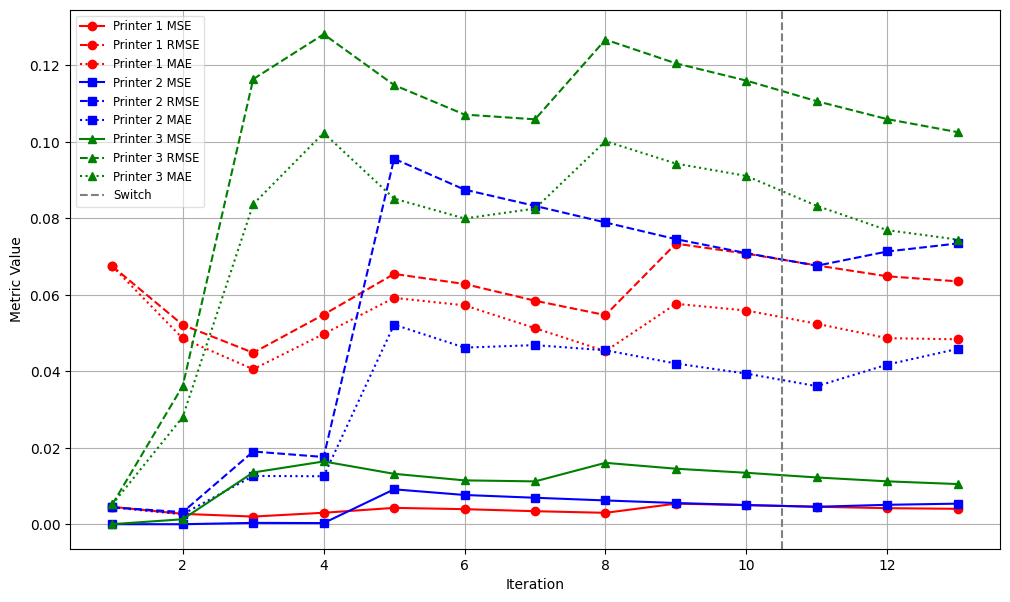

In [ ]:
# Store all metrics for combined plotting
all_mse = []
all_rmse = []
all_mae = []
all_iters = []

for j in range(1, 4):
    print(f"-----------Printer {j}-------------------")
    data_single = pd.read_csv(f"../data/data-experiment-Feb2025-P{j}_15.csv")
    clean_data = np.array(pd.Series(data_single[f'W_P{j}'][225:]).dropna().tolist())
    reshaped = clean_data.reshape(-1, 3)
    reduced = np.mean(reshaped, axis=1)

    W = - abs(1 - reduced/expected_weight)
    iterations = range(len(W))

    predictions = []
    for i in range(14):
        with open(f"../BO/Metadata/metadata_after_BOP{j}_{i+1}_Feb2025.yaml") as stream:
            try:
                metadata = yaml.safe_load(stream)
                predictions.append(eval(metadata["values"])[0][0]*-1)
            except yaml.YAMLError as exc:
                print(exc)

    current_max = []
    max_multi = W[0]
    for value in W:
        if value > max_multi:
            max_multi = value
        current_max.append(max_multi)

    # Compute metrics on slices of data
    mse_values = []
    rmse_values = []
    mae_values = []
    iters = []
    W1 = W[1:]
    pred0 = predictions[0:-1]
    for i, (w, pred) in enumerate(zip(W1, pred0), start=1):
        mse, rmse, mae = compute_metrics(W1[:i], pred0[:i])
        mse_values.append(mse)
        rmse_values.append(rmse)
        mae_values.append(mae)
        iters.append(i)

    all_mse.append(mse_values)
    all_rmse.append(rmse_values)
    all_mae.append(mae_values)
    all_iters.append(iters)
    
    print(f"Best value found: {current_max[-1]}")
    print(f"Prediction error: {abs(np.array(predictions[0:-2]) - np.array(W[1:-1]))}")

# Now plot combined metrics for all printers
plt.figure(figsize=(12, 7))

metric_names = ['MSE', 'RMSE', 'MAE']
linestyles = ['-', '--', ':']

for printer_idx in range(3):
    iters = all_iters[printer_idx]
    for metric_idx, metric_values in enumerate([all_mse[printer_idx], all_rmse[printer_idx], all_mae[printer_idx]]):
        plt.plot(iters, metric_values,
                 label=f'Printer {printer_idx+1} {metric_names[metric_idx]}',
                 color=colors[printer_idx],
                 marker=markers[printer_idx],
                 linestyle=linestyles[metric_idx],
                 markersize=6)

plt.axvline(x=10.5, color='gray', linestyle='--', label='Switch')

plt.xlabel('Iteration')
plt.ylabel('Metric Value')
leg = plt.legend(loc='upper left', fontsize='small')

# Set transparency of legend frame (box)
leg.get_frame().set_alpha(0.6)  # Adjust this value (0 = invisible, 1 = opaque)

plt.grid(True)
plt.savefig("Figures_Postprocessing/singleopt_metrics_combined.png", format='png', dpi=600)
plt.show()


### 2.1 Check convergence for multi optimization and plot

In [ ]:
data_multi = pd.read_csv("../data/data-experiment-15.csv")

In [6]:
clean_data_1 = np.array(pd.Series(data_multi['W_P1'][225:]).dropna().tolist())
reshaped_1 = clean_data_1.reshape(-1, 3)
reduced_1 = np.mean(reshaped_1, axis=1)

clean_data_2 = np.array(pd.Series(data_multi['W_P2'][225:]).dropna().tolist())
reshaped_2 = clean_data_2.reshape(-1, 3)
reduced_2 = np.mean(reshaped_2, axis=1)

clean_data_3 = np.array(pd.Series(data_multi['W_P3'][225:]).dropna().tolist())
reshaped_3 = clean_data_3.reshape(-1, 3)
reduced_3 = np.mean(reshaped_3, axis=1)

In [7]:
volume = 80 * 13 * 3.2 * 1e-3
expected_density = 1.24 #from the PLA datasheet 
#https://www.materialdatacenter.com/ms/en/Ingeo/NatureWorks+LLC/Ingeo%E2%84%A2+3251D/f483c129/5616
expected_weight = volume * expected_density
print(expected_weight)
W_P1 = - abs(1-reduced_1/expected_weight)
W_P2 = - abs(1-reduced_2/expected_weight)
W_P3 = - abs(1-reduced_3/expected_weight)

4.126720000000001


In [ ]:
iterations = range(0,len(W_P1))
expected_1 = []
expected_2 = []
expected_3 = []

for i in range(1,15):
    with open("../BO/Metadata/metadata_after_BO"+str(i)+".yaml") as stream:
        try:
            metadata = yaml.safe_load(stream)
            expected_1.append(eval(metadata["values"])[0][0])
            expected_2.append(eval(metadata["values"])[1][0])
            expected_3.append(eval(metadata["values"])[2][0])
        except yaml.YAMLError as exc:
            print(exc)

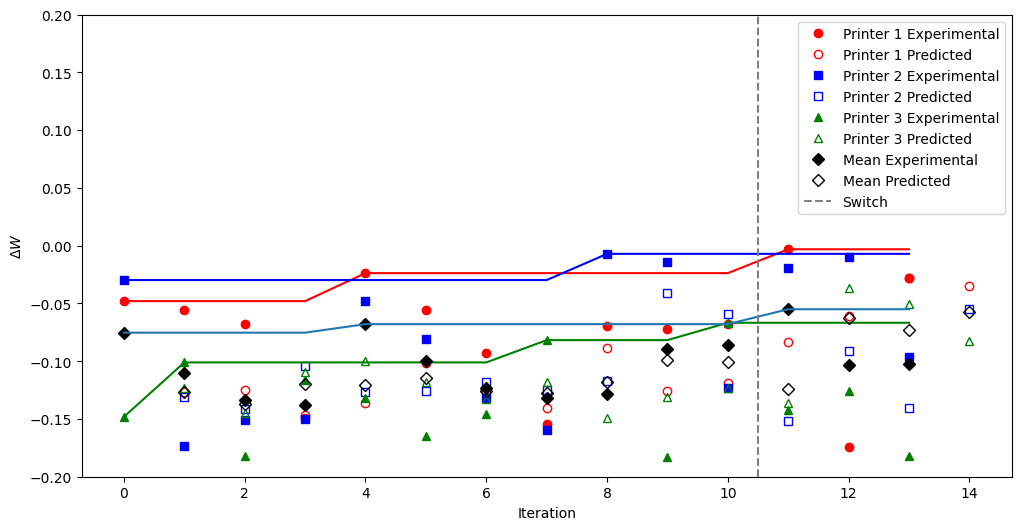

In [9]:
colors = ['red', 'blue', 'green']            # Printer colors
markers = ['o', 's', '^']                     # Circle, square, triangle markers for printers
mean_marker = 'D'                             # Diamond marker for mean

labels_exp = ['Printer 1 Experimental', 'Printer 2 Experimental', 'Printer 3 Experimental']
labels_pred = ['Printer 1 Predicted', 'Printer 2 Predicted', 'Printer 3 Predicted']
labels_max = ['Printer 1 Max', 'Printer 2 Max', 'Printer 3 Max']

plt.figure(figsize=(12, 6))

all_W = [W_P1, W_P2, W_P3]
all_expected = [expected_1, expected_2, expected_3]

# Plot for each printer
for i in range(3):
    W = all_W[i]
    expected = all_expected[i]

    max_val = W[0]
    current_max = []
    for val in W:
        if val > max_val:
            max_val = val
        current_max.append(max_val)
    iterations = range(len(W))
    iterpred = range(1, len(expected) + 1)

    # Experimental data points (filled markers)
    plt.plot(iterations, W, color=colors[i], marker=markers[i], linestyle='None', label=labels_exp[i])
    # Predicted data points (unfilled markers)
    plt.plot(iterpred, expected, color=colors[i], marker=markers[i], linestyle='None', fillstyle='none', label=labels_pred[i])
    # Current max line
    plt.plot(iterations, current_max, color=colors[i])#, linestyle='-', label=labels_max[i])

# Compute mean quantities
W_mean = (W_P1 + W_P2 + W_P3) / 3
expected_mean = (np.array(expected_1) + np.array(expected_2) + np.array(expected_3)) / 3

max_mean_val = W_mean[0]
current_max_mean = []
for val in W_mean:
    if val > max_mean_val:
        max_mean_val = val
    current_max_mean.append(max_mean_val)
iterations = range(len(W_mean))
iterpred = range(1, len(W_mean) + 1)

# Plot mean in black with diamond markers
plt.plot(iterations, W_mean, 'k' + mean_marker, linestyle='None', label='Mean Experimental')
plt.plot(iterpred, expected_mean, 'k' + mean_marker, fillstyle='none', linestyle='None', label='Mean Predicted')
plt.plot(iterations, current_max_mean)#, 'k-', label='Mean Max')

# Vertical switch line added once
plt.axvline(x=10.5, color='gray', linestyle='--', label='Switch')

#plt.title("Multi-task Optimization: Printers & Mean with Distinct Markers")
plt.xlabel("Iteration")
plt.ylabel("$\Delta W$")
plt.ylim([-0.2, 0.2])
plt.legend(loc='best')
plt.savefig("Figures_Postprocessing/multiopt_convergence_plot_all_mean_markers.png", format='png', dpi=600)
plt.show()


### 2.2 Calculate multi optimization metrics and plot

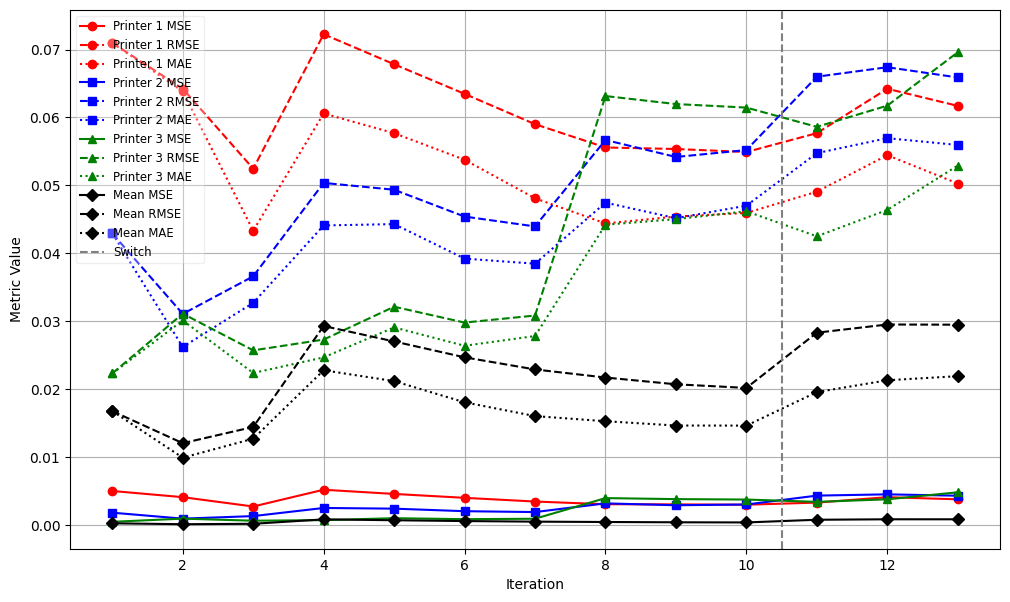

In [10]:
# Prepare lists for each printer and the mean
all_W = [W_P1[1:], W_P2[1:], W_P3[1:]]
all_pred = [expected_1[:-1], expected_2[:-1], expected_3[:-1]]
labels = ['Printer 1', 'Printer 2', 'Printer 3', 'Mean']
colors = ['red', 'blue', 'green', 'black']
markers = ['o', 's', '^', 'D']

# Compute mean values arrays
W_mean = (W_P1 + W_P2 + W_P3) / 3
expected_mean = (np.array(expected_1) + np.array(expected_2) + np.array(expected_3)) / 3

all_W.append(W_mean[1:])
all_pred.append(expected_mean[:-1])

plt.figure(figsize=(12, 7))

for i in range(4):
    mse_values = []
    rmse_values = []
    mae_values = []
    iters = []
    W_vals = all_W[i]
    pred_vals = all_pred[i]

    for iter_idx in range(1, len(W_vals)+1):
        mse, rmse, mae = compute_metrics(W_vals[:iter_idx], pred_vals[:iter_idx])
        mse_values.append(mse)
        rmse_values.append(rmse)
        mae_values.append(mae)
        iters.append(iter_idx)

    # Plot MSE
    plt.plot(iters, mse_values, label=f'{labels[i]} MSE', color=colors[i], marker=markers[i], linestyle='-')
    # Plot RMSE
    plt.plot(iters, rmse_values, label=f'{labels[i]} RMSE', color=colors[i], marker=markers[i], linestyle='--')
    # Plot MAE
    plt.plot(iters, mae_values, label=f'{labels[i]} MAE', color=colors[i], marker=markers[i], linestyle=':')

# Vertical switch line
plt.axvline(x=10.5, color='gray', linestyle='--', label='Switch')

plt.xlabel("Iteration")
plt.ylabel("Metric Value")
leg = plt.legend(loc='upper left', fontsize='small')

# Set transparency of legend frame (box)
leg.get_frame().set_alpha(0.3)  # Adjust this value (0 = invisible, 1 = opaque)

# Set transparency for legend texts
#for text in leg.get_texts():
#    text.set_alpha(0.3)
plt.grid(True)
plt.savefig("Figures_Postprocessing/multiopt_metrics_combined.png", format='png', dpi=600)
plt.show()
